**Required output_attr_stats.csv, adj_folder, and centrality_folder**

# import data

In [43]:
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from datetime import datetime
from tqdm.auto import tqdm,trange
import warnings
import logging
import scipy.sparse
import os
# import altair as alt
# from vega_datasets import data
warnings.filterwarnings("ignore") 
logging.getLogger('matplotlib.font_manager').disabled = True

In [44]:
def seperate_emails(df_email, by, date_col = 'date_sent'):
    '''
    seperate emails by stage or month
    
    df_email: dataframe with email records 
    by: how to seperate, either by month or by stage
    date_col: name of the date column in df_email
    return: idxes: list of indices, corresponds to each splitting period
    return: idx_labels: list of labels, corresponds to each splitting period
    return: label_colors: dict of label:color, corresponds to each splitting period
    '''
    assert by in ['month', 'stage'], 'not implemented'
    date_email = pd.to_datetime(df_email[date_col])
    colors = ['green', 'blue', 'red', 'orange']
    
    if by == 'stage':
        idxt1 = date_email>datetime(2014,1,23)
        idxt2 = date_email>datetime(2014,5,14)
        idxt3 = date_email>datetime(2016,2,24)
        idxe1 = np.array(idxt1==False)
        idxe2 = np.array((idxt1==True) & (idxt2==False))
        idxe3 = np.array((idxt2==True) & (idxt3==False))
        idxe4 = np.array(idxt3==True)

        idxes = [idxe1, idxe2, idxe3, idxe4]
        idx_labels = ['before 2014,1,23', '2014,1,23 - 2014,5,14', '2014,5,14 - 2016,2,24', 'after 2016,2,24']
        label_colors = {}
        for label, color in zip(idx_labels, colors):
            label_colors[label] = color
    elif by == 'month':
        month = date_email.dt.month
        year = date_email.dt.year
        idxes = []
        idx_labels = []
        
        color = colors[0]
        label_colors = {}
        skip = True # skip initial empty months and ending months
        for y in range(int(year.min()),int(year.max()+1)):
            for m in range(1,13):
                idx = (year == y) * (month == m)
                if idx.sum() == 0 and skip == True:
                    continue
                else:
                    skip = False
                    idxes.append(np.array(idx))
                    label = str(y)+'.'+str(m)
                    idx_labels.append(label)
                    label_colors[label] = color
                    if label == '2014.1':
                        color = colors[1]
                    elif label == '2014.5':
                        color = colors[2]
                    elif label == '2016.2':
                        color = colors[3]
        for i,idx in enumerate(idxes[::-1]): # remove the empty months in the end
            if idx.sum() != 0:
                break
        idxes = idxes[:-i]
        idx_labels = idx_labels[:-i]
    return idxes, idx_labels, label_colors

In [45]:
def cal_graph_stats(adj_folder, idxes, by):
    graph_stats = np.zeros((len(idxes),2))
    for k in trange(len(idxes)):
        infile = adj_folder+'/adjmat_'+by+'_'+str(k)+'.npz'
        if os.path.exists(infile):
            sparse_matrix = scipy.sparse.load_npz(infile)
            email_adj_mat = np.asarray(sparse_matrix.todense())
            G = nx.from_numpy_array(email_adj_mat, create_using=nx.DiGraph)
            graph_stats[k,0] = nx.density(G)  # network density
            graph_stats[k,1] = ((email_adj_mat.sum(axis=0) != 0) * (email_adj_mat.sum(axis=1) != 0)).sum()/G.size() # number of active nodes
        else: # if file not exist, it means there are no email found during that period. Remain 0
            print(f'infile {infile} not found! Indicating no email found during the period.')
            pass
    return graph_stats

In [46]:
def cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name):
    centrality_stats = np.zeros((len(idxes),4))
    for k in trange(len(idxes)):
        infile = centrality_folder+'/'+by+'_'+str(k)+'_alpha_'+str(alpha)+'_'+centrality_name+'.npz'
        if os.path.exists(infile):
            sparse_matrix = scipy.sparse.load_npz(infile)
            centr = np.asarray(sparse_matrix.todense()).reshape(-1)
            centrality_stats[k,0] = centr.min()
            centrality_stats[k,1] = centr.mean()
            centrality_stats[k,2] = centr.max()
            centrality_stats[k,3] = centr.std()
        else:
            print(f'infile {infile} not found! Indicating no email found during the period.')
            pass
    return centrality_stats

In [5]:
def centrality_density_plot(graph_stats, centrality_stats, idxes, idx_labels, label_colors, title, start_idx = 0):
    fig, ax1 = plt.subplots(figsize = (15,4))

    x = centrality_stats[start_idx:,1]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(title, fontsize = 24)
    ax1.bar(np.arange(len(idxes)-start_idx), x, label = 'avg centrality', alpha = 0.6, color = 'black')
    ax1.legend(loc=2)
    # the range is too large
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,10], y2 = centrality[:,8], color = 'red', alpha = 0.3)
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,9] + centrality[:,11], y2 = centrality[:,9] - centrality[:,11], color = 'red', alpha = 0.3)
    ax1.set_xticks(np.arange(len(idxes)-start_idx))
    ax1.set_xticklabels(idx_labels[start_idx:], rotation = 90, fontsize = 14)
    ax1.set_xlabel('time', fontsize = 16)
    ax1.set_ylabel('avg centrality', color='black', fontsize = 20)
    ax1.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax1.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    #for ticklabel in plt.gca().get_xticklabels():
    #    ticklabel.set_color(label_colors[ticklabel.get_text()])
    ax1.grid(axis = 'y')

#     x = centrality_stats[start_idx:,3]
#     ax2 = ax1.twinx()
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['bottom'].set_visible(False)
    
    
#     ax2.plot(x ,label = 'std centrality', c = 'black', linewidth = 3, ls = 'dashed')
#     ax2.set_ylabel('std centrality', color='black', fontsize = 20, x = 2.4, y = 0.5)
#     ax2.yaxis.set_label_coords(-0.14 ,0.5) 
#     ax2.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax2.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax2.legend(loc=2, bbox_to_anchor=(0.0,0.9))

    x =centrality_stats[start_idx:,3]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.plot(x, label = 'std centrality', c = 'black', linewidth = 3, alpha = 0.6)
    ax3.set_ylabel('std centrality', color='black', fontsize = 20)
    ax3.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax3.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    ax3.legend(loc=1)


    #x = graph_stats[start_idx:,1]
    
    #ax4 = ax1.twinx()
    #ax4.spines['right'].set_visible(False)
    #ax4.spines['left'].set_visible(False)
    #ax4.spines['top'].set_visible(False)
#     ax4.spines['bottom'].set_visible(False)
#     ax4.spines["right"].set_position(("axes", 1.08))
#     ax4.plot(x, label = 'modified density', c = 'black', linewidth = 2, alpha = 0.6)
#     ax4.set_ylabel('modified density', color='black', fontsize = 20, x = 1.2, y = 0.5)
#     ax4.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax4.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax4.legend(loc=1, bbox_to_anchor=(1.0,0.9))

    plt.tight_layout()
  #  plt.show()
    plt.savefig("delete planner closeness centrality.png",dpi=300)
    

In [6]:
sparse_matrix = scipy.sparse.load_npz('/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/centrality_weighted_03212022/month_45_alpha_1_betweenness.npz')



In [7]:
centr = np.asarray(sparse_matrix.todense())

In [8]:
centr.shape

(1, 25074)

In [9]:
len(np.unique(centr))

68

# draw graph with planner. planner no merge.

In [49]:
df_email = pd.read_csv('output_attr_stats.csv')

In [50]:
by = 'month'
idxes, idx_labels, label_colors = seperate_emails(df_email, by, date_col = 'date_sent')

In [51]:
adj_folder = "./undirected_adj_03212022"
graph_stats = cal_graph_stats(adj_folder, idxes, by)

infile ./undirected_adj_03212022/adjmat_month_0.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_1.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_2.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_3.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_4.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_5.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_6.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_7.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_8.npz not found! Indicating no email found during the period.
infile ./undirected_adj_0321

In [52]:
centrality_folder = "./centrality_weighted_03212022"
centrality_name = 'closeness'
alpha = 1
closeness_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)

infile ./centrality_weighted_03212022/month_1_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_2_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_3_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_4_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_5_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_6_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_7_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_8_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile .

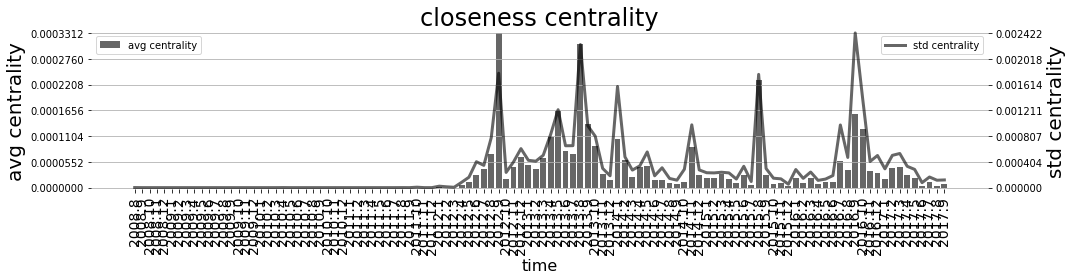

In [13]:
title = 'closeness centrality'
centrality_density_plot(graph_stats, closeness_stats, idxes, idx_labels, label_colors, title)

In [53]:
title = 'Closeness Centrality'
centrality_density_plot(graph_stats, closeness_stats, idxes, idx_labels, label_colors, title, start_idx=36)


NameError: name 'centrality_density_plot' is not defined

In [16]:
centrality_folder = "./centrality_weighted_03212022"
centrality_name = 'betweenness'
alpha = 1
betweenness_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)

infile ./centrality_weighted_03212022/month_1_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_2_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_3_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_4_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_5_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_6_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_7_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_8_alpha_1_betweenness.npz not found! Indicating no email found during the 

In [17]:
# title = 'Betweenness Centrality'
# centrality_density_plot(graph_stats, betweenness_stats, idxes, idx_labels, label_colors, title)

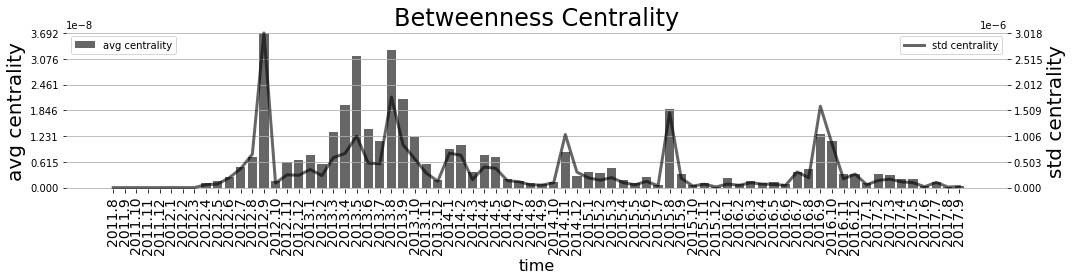

In [18]:
title = 'Betweenness Centrality'
centrality_density_plot(graph_stats, betweenness_stats, idxes, idx_labels, label_colors, title, start_idx=36)

In [18]:
centrality_folder = "./centrality_weighted_03212022"
centrality_name = 'degree'
alpha = 1
degree_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)

infile ./centrality_weighted_03212022/month_1_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_2_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_3_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_4_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_5_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_6_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_7_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_8_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_032

In [62]:
#random walk 

centrality_folder = "./centrality_weighted_03212022"
centrality_name = 'random_walk_bc'
alpha = 1
random_walk_bc_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)




infile ./centrality_weighted_03212022/month_1_alpha_1_random_walk_bc.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_2_alpha_1_random_walk_bc.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_3_alpha_1_random_walk_bc.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_4_alpha_1_random_walk_bc.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_5_alpha_1_random_walk_bc.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_6_alpha_1_random_walk_bc.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_7_alpha_1_random_walk_bc.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_8_alpha_1_random_walk_bc.npz not found! Indicating no

In [67]:
random_walk_bc_stats.shape


(110, 4)

In [70]:
random_walk_bc_stats[:,1].shape

(110,)

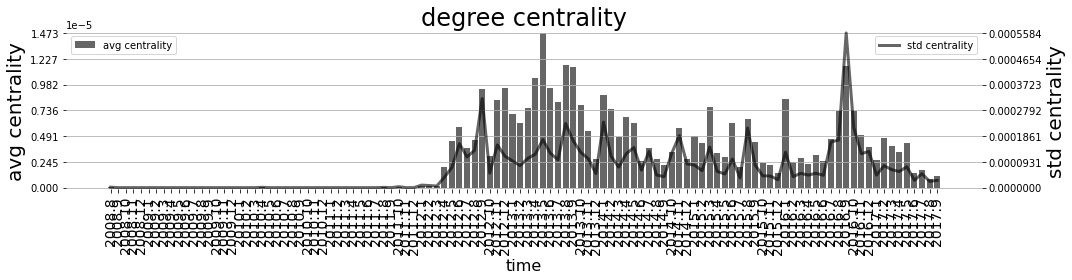

In [18]:
# title = 'degree centrality'
# centrality_density_plot(graph_stats, degree_stats, idxes, idx_labels, label_colors, title)

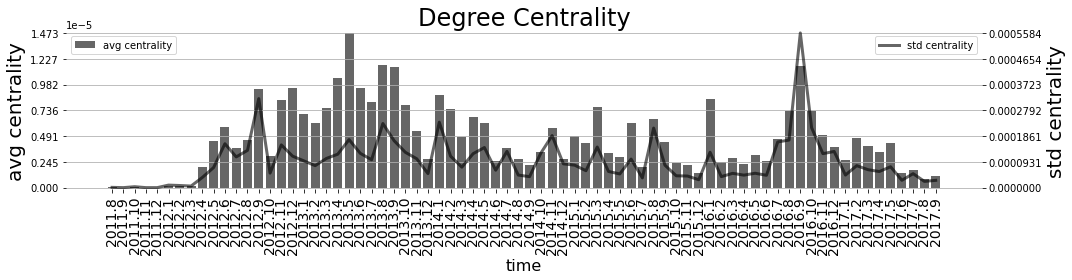

In [20]:
title = 'Degree Centrality'
centrality_density_plot(graph_stats, degree_stats, idxes, idx_labels, label_colors, title, start_idx=36)

## change the x axis bar to 2012.1,,,,6.,,,,12

In [68]:
def centrality_density_plot_x_axis(graph_stats, centrality_stats, idxes, idx_labels, label_colors, title, start_idx = 0):
    fig, ax1 = plt.subplots(figsize = (15,4))

    x = centrality_stats[start_idx:,1]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(title, fontsize = 24)
    ax1.bar(np.arange(len(idxes)-start_idx), x, label = 'avg centrality', alpha = 0.6, color = 'black')
    ax1.legend(loc=2)
    # the range is too large
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,10], y2 = centrality[:,8], color = 'red', alpha = 0.3)
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,9] + centrality[:,11], y2 = centrality[:,9] - centrality[:,11], color = 'red', alpha = 0.3)
    ax1.set_xticks(np.arange(len(idxes)-start_idx))
    #ax1.set_xticklabels(idx_labels[start_idx:], rotation = 90, fontsize = 14)
    print(idx_labels[start_idx:])
    
    ax1.set_xlabel('time', fontsize = 16)
    ax1.set_ylabel('avg centrality', color='black', fontsize = 20)
    ax1.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax1.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    #for ticklabel in plt.gca().get_xticklabels():
    #    ticklabel.set_color(label_colors[ticklabel.get_text()])
    ax1.grid(axis = 'y')

#     x = centrality_stats[start_idx:,3]
#     ax2 = ax1.twinx()
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['bottom'].set_visible(False)
    
    
#     ax2.plot(x ,label = 'std centrality', c = 'black', linewidth = 3, ls = 'dashed')
#     ax2.set_ylabel('std centrality', color='black', fontsize = 20, x = 2.4, y = 0.5)
#     ax2.yaxis.set_label_coords(-0.14 ,0.5) 
#     ax2.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax2.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax2.legend(loc=2, bbox_to_anchor=(0.0,0.9))

    x =centrality_stats[start_idx:,3]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.plot(x, label = 'std centrality', c = 'black', linewidth = 3, alpha = 0.6)
    ax3.set_ylabel('std centrality', color='black', fontsize = 20)
    ax3.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax3.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    ax3.legend(loc=1)


    #x = graph_stats[start_idx:,1]
    
    #ax4 = ax1.twinx()
    #ax4.spines['right'].set_visible(False)
    #ax4.spines['left'].set_visible(False)
    #ax4.spines['top'].set_visible(False)
#     ax4.spines['bottom'].set_visible(False)
#     ax4.spines["right"].set_position(("axes", 1.08))
#     ax4.plot(x, label = 'modified density', c = 'black', linewidth = 2, alpha = 0.6)
#     ax4.set_ylabel('modified density', color='black', fontsize = 20, x = 1.2, y = 0.5)
#     ax4.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax4.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax4.legend(loc=1, bbox_to_anchor=(1.0,0.9))

    plt.tight_layout()
    plt.show()
#     plt.savefig("delete planner closeness centrality.png",dpi=300)
    

In [21]:


# title = 'Degree Centrality'
# centrality_density_plot_x_axis(graph_stats, degree_stats, idxes, idx_labels, label_colors, title, start_idx=36)


In [22]:
new_x_axis=['2011.8', ' ', ' ', ' ', '12', '2012.1', ' ', ' ', ' ', ' ',
            '6', ' ', ' ', ' ', ' ', ' ', ' 12', '2013.1', ' ', ' ',
            ' ', ' ', '6', ' ', ' ', ' ', ' ', ' ', '12', '2014.1', 
            ' ', ' ', ' ', ' ', '6', ' ', ' ', ' ', ' ', ' ', 
            '12', '2015.1', ' ', ' ', ' ', ' ', '6',  ' ', ' ', ' ', ' ', ' ', 
            '12', '2016.1',  ' ', ' ',
            ' ', ' ', '6', ' ', ' ', ' ', ' ', ' ', '12', '2017.1', ' ', ' ', ' ', ' ', 
            '6', ' ', ' ', '9']

In [23]:
new_x_axis2=['2011.8', ' ', ' ', ' ', ' ', '2012.1', ' ', ' ', ' ', ' ',
            '6', ' ', ' ', ' ', ' ', ' ', '  ', '2013.1', ' ', ' ',
            ' ', ' ', '6', ' ', ' ', ' ', ' ', ' ', ' ', '2014.1', 
            ' ', ' ', ' ', ' ', '6', ' ', ' ', ' ', ' ', ' ', 
            ' ', '2015.1', ' ', ' ', ' ', ' ', '6',  ' ', ' ', ' ', ' ', ' ', 
            ' ', '2016.1',  ' ', ' ',
            ' ', ' ', '6', ' ', ' ', ' ', ' ', ' ', ' ', '2017.1', ' ', ' ', ' ', ' ', 
            '6', ' ', ' ', '9']

In [24]:
def centrality_density_plot_x_axis2(graph_stats, centrality_stats, idxes, idx_labels, label_colors, title, start_idx = 0):
    fig, ax1 = plt.subplots(figsize = (15,4))

    x = centrality_stats[start_idx:,1]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(title, fontsize = 24)
    ax1.bar(np.arange(len(idxes)-start_idx), x, label = 'avg centrality', alpha = 0.6, color = 'black')
    ax1.legend(loc=2)
    # the range is too large
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,10], y2 = centrality[:,8], color = 'red', alpha = 0.3)
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,9] + centrality[:,11], y2 = centrality[:,9] - centrality[:,11], color = 'red', alpha = 0.3)
    new_x_axis1=['2011.8', ' ', ' ', ' ', ' ', '2012.1', ' ', ' ', ' ', ' ',
            '6', ' ', ' ', ' ', ' ', ' ', '  ', '2013.1', ' ', ' ',
            ' ', ' ', '6', ' ', ' ', ' ', ' ', ' ', ' ', '2014.1', 
            ' ', ' ', ' ', ' ', '6', ' ', ' ', ' ', ' ', ' ', 
            ' ', '2015.1', ' ', ' ', ' ', ' ', '6',  ' ', ' ', ' ', ' ', ' ', 
            ' ', '2016.1',  ' ', ' ',
            ' ', ' ', '6', ' ', ' ', ' ', ' ', ' ', ' ', '2017.1', ' ', ' ', ' ', ' ', 
            '6', ' ', ' ', '9']
    
    new_x_axis2=['8', ' ', '2011', ' ', '12', '1', ' ', ' ', ' ', '2012',
            '6', ' ', ' ', ' ', ' ', ' ', '12', '1', ' ', ' ',
            ' ', '2013', '6', ' ', ' ', ' ', ' ', ' ', '12', '1', 
            ' ', ' ', ' ', '2014', '6', ' ', ' ', ' ', ' ', ' ', 
            '12', '1', ' ', ' ', ' ', '2015', '6',  ' ', ' ', ' ', ' ', ' ', 
            '12', '1',  ' ', ' ',
            ' ', '2016', '6', ' ', ' ', ' ', ' ', ' ', '12', '1', ' ', ' ', ' ', '2017', 
            '6', ' ', ' ', '9']
    new_x_axis3=['8', ' ', '2011', ' ', '12', ' ', ' ', ' ', ' ', '2012',
            '6', ' ', ' ', ' ', ' ', ' ', '12', ' ', ' ', ' ',
            ' ', '2013', '6', ' ', ' ', ' ', ' ', ' ', '12', ' ', 
            ' ', ' ', ' ', '2014', '6', ' ', ' ', ' ', ' ', ' ', 
            '12', ' ', ' ', ' ', ' ', '2015', '6',  ' ', ' ', ' ', ' ', ' ', 
            '12', ' ',  ' ', ' ',
            ' ', '2016', '6', ' ', ' ', ' ', ' ', ' ', '12', ' ', ' ', ' ', ' ', '2017', 
            '6', ' ', ' ', '9']
    new_x_axis4=['2011.Aug', '2011.Sep', ' ', '2011.Nov', ' ', '2012.Jan', ' ', ' ', ' ', ' ',
            'Jun', ' ', ' ', ' ', ' ', ' ', '  ', '2013.Jan', ' ', ' ',
            ' ', ' ', 'Jun', ' ', ' ', ' ', ' ', ' ', '2013.Dec', '2014.Jan', 
            ' ', ' ', ' ', ' ', 'Jun', ' ', '2014.Aug', ' ', ' ', ' ', 
            ' ', '2015.Jan', ' ', ' ', ' ', ' ', 'Jun',  ' ', ' ', ' ', ' ', ' ', 
            ' ', '2016.Jan',  '2016.Feb', ' ',
            ' ', ' ', 'Jun', ' ', ' ', ' ', ' ', ' ', ' ', '2017.Jan', ' ', ' ', ' ', ' ', 
            'Jun', ' ', ' ', 'Sep']
    
    ax1.set_xticks(np.arange(len(idxes)-start_idx))
    ax1.set_xticklabels(new_x_axis4, rotation = 90, fontsize = 14)
    
#     x_ticks_pos_vertical = [0, 0, -0.08, 0, 0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0,
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0,
#                             0,0,0,0,-0.08,0,0,0,0]

#     for t, y in zip(ax1.get_xticklabels(), x_ticks_pos_vertical):
#         t.set_y(y)
#     print(idx_labels[start_idx:])
    
    
    ax1.set_xlabel('time', fontsize = 16)
    ax1.set_ylabel('avg centrality', color='black', fontsize = 20)
    ax1.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax1.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    #for ticklabel in plt.gca().get_xticklabels():
    #    ticklabel.set_color(label_colors[ticklabel.get_text()])
    ax1.grid(axis = 'y')

#     x = centrality_stats[start_idx:,3]
#     ax2 = ax1.twinx()
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['bottom'].set_visible(False)
    
    
#     ax2.plot(x ,label = 'std centrality', c = 'black', linewidth = 3, ls = 'dashed')
#     ax2.set_ylabel('std centrality', color='black', fontsize = 20, x = 2.4, y = 0.5)
#     ax2.yaxis.set_label_coords(-0.14 ,0.5) 
#     ax2.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax2.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax2.legend(loc=2, bbox_to_anchor=(0.0,0.9))

    x =centrality_stats[start_idx:,3]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.plot(x, label = 'std centrality', c = 'black', linewidth = 3, alpha = 0.6)
    ax3.set_ylabel('std centrality', color='black', fontsize = 20)
    ax3.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax3.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    ax3.legend(loc=1)


    #x = graph_stats[start_idx:,1]
    
    #ax4 = ax1.twinx()
    #ax4.spines['right'].set_visible(False)
    #ax4.spines['left'].set_visible(False)
    #ax4.spines['top'].set_visible(False)
#     ax4.spines['bottom'].set_visible(False)
#     ax4.spines["right"].set_position(("axes", 1.08))
#     ax4.plot(x, label = 'modified density', c = 'black', linewidth = 2, alpha = 0.6)
#     ax4.set_ylabel('modified density', color='black', fontsize = 20, x = 1.2, y = 0.5)
#     ax4.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax4.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax4.legend(loc=1, bbox_to_anchor=(1.0,0.9))

    plt.tight_layout()
    plt.show()
#     plt.savefig(title+"20230527 v4.png",dpi=300)
    

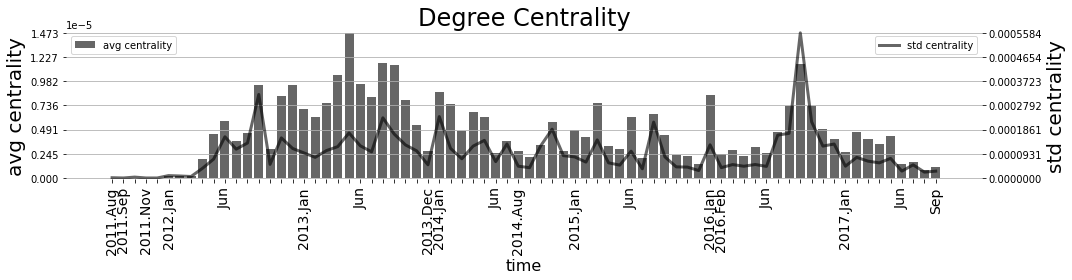

In [25]:
title = 'Degree Centrality'
centrality_density_plot_x_axis2(graph_stats, degree_stats, idxes, idx_labels, label_colors, title, start_idx=36)


In [28]:
# title = 'Closeness Centrality'
# centrality_density_plot_x_axis2(graph_stats, degree_stats, idxes, idx_labels, label_colors, title, start_idx=36)


## random walk bc: change the color of the bar

color option:
https://matplotlib.org/stable/gallery/color/named_colors.html

In [71]:
def centrality_density_plot_x_axis2_color(graph_stats, centrality_stats, idxes, idx_labels, label_colors, title, start_idx = 0):
    fig, ax1 = plt.subplots(figsize = (15,4))

    x = centrality_stats[start_idx:,1]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(title, fontsize = 24)
    
    #find the location top 15 percentile
    #find the location bottom 15 percentile
    
    # Example list of values
    values = degree_stats[start_idx:,1]

    # Calculate the 85th percentile
    percentile_85 = np.percentile(values, 85)
    percentile_15 = np.percentile(values, 15)

    # Find the indices of values greater than or equal to the 15th percentile
    top_85 = [i for i, value in enumerate(values) if value >= percentile_85]
    low_15= [i for i, value in enumerate(values) if value <= percentile_15]
    middle=[i for i, value in enumerate(values) if (value > percentile_15)&(value < percentile_85)]
    
    
    #ax1.bar(np.arange(len(idxes)-start_idx), x, label = 'avg centrality', alpha = 0, color = 'black')
    
    
    ax1.plot(x, label = 'avg centrality', c = 'black', linewidth = 3, alpha = 0)
    
#     # Add a legend
#     legend = ax1.legend()

#     # Get the legend's line objects
#     legend_lines = legend.get_lines()

#     # Change the symbol color of each line in the legend
#     for line in legend_lines:
#         print(line)
#         line.set_color('red')
    
    

    # Print the indices
    print(top_85)
    print(low_15)

   
    selected_bars1 = top_85
    for i in selected_bars1:
        ax1.bar(np.arange(len(idxes)-start_idx)[i], x[i],alpha = 0.25, color = 'black') #change bar color;alpha = 0.25,
    
    selected_bars2 = low_15
    for i in selected_bars2:
        ax1.bar(np.arange(len(idxes)-start_idx)[i], x[i] ,alpha = 1, color = 'black') #change bar color,alpha = 0.5,
    
    selected_bars3 = middle
    for i in selected_bars3:
        ax1.bar(np.arange(len(idxes)-start_idx)[i], x[i] ,alpha = 0.5, color = 'black') #change bar color,alpha = 0.5,

    
    
    
    legend =ax1.legend(loc=2)
    
    
    # change the legend color

    # Add a legend
    #legend = ax1.legend()

    # Get the legend's patch objects
#     legend_patches = legend.get_patches()

#     # Change the symbol color of each patch in the legend
#     for patch in legend_patches:
#         patch.set_color('black')

    # the range is too large
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,10], y2 = centrality[:,8], color = 'red', alpha = 0.3)
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,9] + centrality[:,11], y2 = centrality[:,9] - centrality[:,11], color = 'red', alpha = 0.3)

    new_x_axis4=['2011.Aug', '2011.Sep', ' ', '2011.Nov', ' ', '2012.Jan', ' ', ' ', ' ', ' ',
            'Jun', ' ', ' ', ' ', ' ', ' ', '  ', '2013.Jan', ' ', ' ',
            ' ', ' ', 'Jun', ' ', ' ', ' ', ' ', ' ', '2013.Dec', '2014.Jan', 
            ' ', ' ', ' ', ' ', 'Jun', ' ', '2014.Aug', ' ', ' ', ' ', 
            ' ', '2015.Jan', ' ', ' ', ' ', ' ', 'Jun',  ' ', ' ', ' ', ' ', ' ', 
            ' ', '2016.Jan',  '2016.Feb', ' ',
            ' ', ' ', 'Jun', ' ', ' ', ' ', ' ', ' ', ' ', '2017.Jan', ' ', ' ', ' ', ' ', 
            'Jun', ' ', ' ', 'Sep']
    
    ax1.set_xticks(np.arange(len(idxes)-start_idx))
    ax1.set_xticklabels(new_x_axis4, rotation = 90, fontsize = 14)
    
#     x_ticks_pos_vertical = [0, 0, -0.08, 0, 0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0,
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0,
#                             0,0,0,0,-0.08,0,0,0,0]

#     for t, y in zip(ax1.get_xticklabels(), x_ticks_pos_vertical):
#         t.set_y(y)
#     print(idx_labels[start_idx:])
    
    
    ax1.set_xlabel('time', fontsize = 16)
    ax1.set_ylabel('avg centrality', color='black', fontsize = 20)
    ax1.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax1.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    #for ticklabel in plt.gca().get_xticklabels():
    #    ticklabel.set_color(label_colors[ticklabel.get_text()])
    ax1.grid(axis = 'y')
    
    

#     x = centrality_stats[start_idx:,3]
#     ax2 = ax1.twinx()
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['bottom'].set_visible(False)
    
    
#     ax2.plot(x ,label = 'std centrality', c = 'black', linewidth = 3, ls = 'dashed')
#     ax2.set_ylabel('std centrality', color='black', fontsize = 20, x = 2.4, y = 0.5)
#     ax2.yaxis.set_label_coords(-0.14 ,0.5) 
#     ax2.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax2.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax2.legend(loc=2, bbox_to_anchor=(0.0,0.9))

    x =centrality_stats[start_idx:,3]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.plot(x, label = 'std centrality', c = 'black', linewidth = 3, alpha = 0.85)
    ax3.set_ylabel('std centrality', color='black', fontsize = 20)
    ax3.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax3.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    ax3.legend(loc=1)
    


    #x = graph_stats[start_idx:,1]
    
    #ax4 = ax1.twinx()
    #ax4.spines['right'].set_visible(False)
    #ax4.spines['left'].set_visible(False)
    #ax4.spines['top'].set_visible(False)
#     ax4.spines['bottom'].set_visible(False)
#     ax4.spines["right"].set_position(("axes", 1.08))
#     ax4.plot(x, label = 'modified density', c = 'black', linewidth = 2, alpha = 0.6)
#     ax4.set_ylabel('modified density', color='black', fontsize = 20, x = 1.2, y = 0.5)
#     ax4.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax4.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax4.legend(loc=1, bbox_to_anchor=(1.0,0.9))

    plt.tight_layout()
    plt.show()
#     plt.savefig(title+"20230527 different color v7.png",dpi=300)
    

[13, 15, 16, 20, 21, 22, 24, 25, 29, 53, 61]
[0, 1, 2, 3, 4, 5, 6, 7, 70, 72, 73]


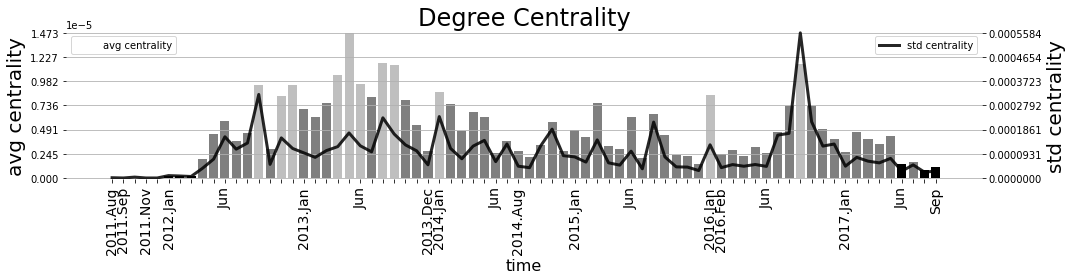

In [67]:
title = 'Degree Centrality'
centrality_density_plot_x_axis2_color(graph_stats, degree_stats, idxes, idx_labels, label_colors, title, start_idx=36)

#这里avg centrality的label的颜色要改一下，改成黑色

In [165]:


def centrality_density_plot_x_axis2_color(graph_stats, centrality_stats, idxes, idx_labels, label_colors, title, start_idx = 0):
    fig, ax1 = plt.subplots(figsize = (15,4))

    x = centrality_stats[start_idx:,1]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(title, fontsize = 24)
    
    #find the location top 15 percentile
    #find the location bottom 15 percentile
    
    # Example list of values
    values = centrality_stats[start_idx:,1]

    # Calculate the 85th percentile
    percentile_85 = np.percentile(values, 85)
    percentile_15 = np.percentile(values, 15)

    # Find the indices of values greater than or equal to the 15th percentile
    top_85 = [i for i, value in enumerate(values) if value >= percentile_85]
    low_15= [i for i, value in enumerate(values) if value <= percentile_15]
    middle=[i for i, value in enumerate(values) if (value > percentile_15)&(value < percentile_85)]
    
    
    #ax1.bar(np.arange(len(idxes)-start_idx), x, label = 'avg centrality', alpha = 0, color = 'black')
    
    
    ax1.plot(x, label = 'avg centrality', c = 'black', linewidth = 3, alpha = 0)
    
#     # Add a legend
#     legend = ax1.legend()

#     # Get the legend's line objects
#     legend_lines = legend.get_lines()

#     # Change the symbol color of each line in the legend
#     for line in legend_lines:
#         print(line)
#         line.set_color('red')
    
    

    # Print the indices
    print(top_85)
    print(low_15)

   
    selected_bars1 = top_85
    for i in selected_bars1:
        ax1.bar(np.arange(len(idxes)-start_idx)[i], x[i],alpha = 0.25, color = 'black') #change bar color;alpha = 0.25,
    
    selected_bars2 = low_15
    for i in selected_bars2:
        ax1.bar(np.arange(len(idxes)-start_idx)[i], x[i] ,alpha = 1, color = 'black') #change bar color,alpha = 0.5,
    
    selected_bars3 = middle
    for i in selected_bars3:
        ax1.bar(np.arange(len(idxes)-start_idx)[i], x[i] ,alpha = 0.5, color = 'black') #change bar color,alpha = 0.5,

    
    
    
    legend =ax1.legend(loc=2)
    
    
    # change the legend color

    # Add a legend
    #legend = ax1.legend()

    # Get the legend's patch objects
#     legend_patches = legend.get_patches()

#     # Change the symbol color of each patch in the legend
#     for patch in legend_patches:
#         patch.set_color('black')

    # the range is too large
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,10], y2 = centrality[:,8], color = 'red', alpha = 0.3)
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,9] + centrality[:,11], y2 = centrality[:,9] - centrality[:,11], color = 'red', alpha = 0.3)

    new_x_axis4=['2011.Aug', '2011.Sep', ' ', '2011.Nov', ' ', '2012.Jan', ' ', ' ', ' ', ' ',
            'Jun', ' ', ' ', ' ', ' ', ' ', '  ', '2013.Jan', ' ', ' ',
            ' ', ' ', 'Jun', ' ', ' ', ' ', ' ', ' ', '2013.Dec', '2014.Jan', 
            ' ', ' ', ' ', ' ', 'Jun', ' ', '2014.Aug', ' ', ' ', ' ', 
            ' ', '2015.Jan', ' ', ' ', ' ', ' ', 'Jun',  ' ', ' ', ' ', ' ', ' ', 
            ' ', '2016.Jan',  '2016.Feb', ' ',
            ' ', ' ', 'Jun', ' ', ' ', ' ', ' ', ' ', ' ', '2017.Jan', ' ', ' ', ' ', ' ', 
            'Jun', ' ', ' ', 'Sep']
    
    ax1.set_xticks(np.arange(len(idxes)-start_idx))
    ax1.set_xticklabels(new_x_axis4, rotation = 90, fontsize = 14)
    
#     x_ticks_pos_vertical = [0, 0, -0.08, 0, 0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0, 
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0,
#                             0,0,0,0,-0.08,0,0,0,0,0,0,0,
#                             0,0,0,0,-0.08,0,0,0,0]

#     for t, y in zip(ax1.get_xticklabels(), x_ticks_pos_vertical):
#         t.set_y(y)
#     print(idx_labels[start_idx:])
    
    
    ax1.set_xlabel('time', fontsize = 16)
    ax1.set_ylabel('avg centrality', color='black', fontsize = 20)
    ax1.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax1.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    #for ticklabel in plt.gca().get_xticklabels():
    #    ticklabel.set_color(label_colors[ticklabel.get_text()])
    ax1.grid(axis = 'y')
    
    

#     x = centrality_stats[start_idx:,3]
#     ax2 = ax1.twinx()
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['bottom'].set_visible(False)
    
    
#     ax2.plot(x ,label = 'std centrality', c = 'black', linewidth = 3, ls = 'dashed')
#     ax2.set_ylabel('std centrality', color='black', fontsize = 20, x = 2.4, y = 0.5)
#     ax2.yaxis.set_label_coords(-0.14 ,0.5) 
#     ax2.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax2.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax2.legend(loc=2, bbox_to_anchor=(0.0,0.9))

    x =centrality_stats[start_idx:,3]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.plot(x, label = 'std centrality', c = 'black', linewidth = 3, alpha = 0.85)
    ax3.set_ylabel('std centrality', color='black', fontsize = 20)
    ax3.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax3.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    ax3.legend(loc=1)
    


    #x = graph_stats[start_idx:,1]
    
    #ax4 = ax1.twinx()
    #ax4.spines['right'].set_visible(False)
    #ax4.spines['left'].set_visible(False)
    #ax4.spines['top'].set_visible(False)
#     ax4.spines['bottom'].set_visible(False)
#     ax4.spines["right"].set_position(("axes", 1.08))
#     ax4.plot(x, label = 'modified density', c = 'black', linewidth = 2, alpha = 0.6)
#     ax4.set_ylabel('modified density', color='black', fontsize = 20, x = 1.2, y = 0.5)
#     ax4.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax4.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax4.legend(loc=1, bbox_to_anchor=(1.0,0.9))

    plt.tight_layout()
#     plt.show()
    plt.savefig(title+"20230605 different color v8.png",dpi=300)
    


In [166]:
random_walk_bc_stats.shape

(110, 4)

[0, 2, 5, 6, 7, 8, 52, 54, 70, 72, 73]
[1, 3, 4, 13, 21, 24, 29, 39, 40, 48, 61]


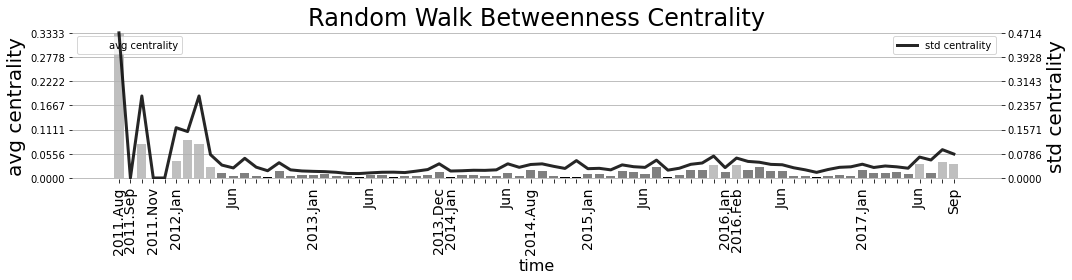

In [167]:



title = 'Random Walk Betweenness Centrality'
centrality_density_plot_x_axis2_color(graph_stats, random_walk_bc_stats, idxes, idx_labels, label_colors, title, start_idx=36)



In [75]:
#average degree centrality
len(degree_stats[36:,1])

74

In [90]:
degree_stats[36:,1]

array([1.27892548e-08, 0.00000000e+00, 4.15650780e-08, 0.00000000e+00,
       0.00000000e+00, 1.79049567e-07, 1.95036135e-07, 1.53471057e-07,
       1.92478284e-06, 4.40909558e-06, 5.72638883e-06, 3.77602747e-06,
       4.51780425e-06, 9.40329957e-06, 2.85520113e-06, 8.23947739e-06,
       9.36173450e-06, 6.92857877e-06, 5.89584645e-06, 7.46253016e-06,
       9.96922410e-06, 1.44262794e-05, 9.35533987e-06, 7.83022124e-06,
       1.15998541e-05, 1.09955618e-05, 7.03089281e-06, 5.17325356e-06,
       2.60581066e-06, 8.54002488e-06, 7.37620269e-06, 4.71603770e-06,
       6.63442591e-06, 5.97897661e-06, 2.38519602e-06, 3.60017522e-06,
       2.35961751e-06, 2.06546465e-06, 3.14295936e-06, 5.41624940e-06,
       2.38199870e-06, 4.64249948e-06, 4.10215347e-06, 7.50409524e-06,
       3.17173518e-06, 2.73370321e-06, 6.10047453e-06, 1.98233449e-06,
       6.38183813e-06, 4.19807288e-06, 2.27648735e-06, 2.02389957e-06,
       1.30770130e-06, 8.43131621e-06, 2.35642019e-06, 2.75288709e-06,
      

In [91]:
degree_stats

array([[0.00000000e+00, 2.55785096e-08, 1.59936026e-04, 1.59880392e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e

In [1]:
# idxes

## pd dataframe network reciprocity value and draw bar chart

In [76]:
# reciprocity2['month_number']=""
#数据结构和centrality 的全部不一样，新的数据结构放入老的数据里面进行画图
#csv file 在 3 build adjacency matrix and calculate centrality_edited_yijia20230520 notebook 里面产生

reciprocity3=pd.read_csv('network_reciprocity_for bar chart.csv')



In [98]:
reciprocity3[:3]

,index,network_reciprocity,month_number
0,adjmat_month_0.npz,0.0,0
1,adjmat_month_20.npz,0.0,20
2,adjmat_month_36.npz,0.0,36


In [84]:
# Identify the column with discontinuous numbers
column = 'month_number'

existing_numbers = set(reciprocity3[column])
min_number = min(existing_numbers)
max_number = max(existing_numbers)
missing_numbers = set(range(min_number, max_number + 1)) - existing_numbers

# Add rows with zeros for the missing numbers
missing_rows = pd.DataFrame({column: list(missing_numbers)})
reciprocity4 = pd.concat([reciprocity3, missing_rows], ignore_index=True)







In [106]:
reciprocity4=reciprocity4.sort_values(by='month_number')


# Fill NaN values with zero
reciprocity4 = reciprocity4.fillna(0)

reciprocity4=reciprocity4.reset_index(drop=True)


In [118]:
reciprocity4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                110 non-null    object 
 1   network_reciprocity  110 non-null    float64
 2   month_number         110 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ KB


In [138]:
reciprocity4[['new1','new2','new3']]=0

In [139]:
reciprocity4

,index,network_reciprocity,month_number,"(new1, new2, new3)",new1,new2,new3
0,adjmat_month_0.npz,0.000000,0,0,0,0,0
1,0,0.000000,1,0,0,0,0
2,0,0.000000,2,0,0,0,0
3,0,0.000000,3,0,0,0,0
4,0,0.000000,4,0,0,0,0
5,0,0.000000,5,0,0,0,0
6,0,0.000000,6,0,0,0,0
7,0,0.000000,7,0,0,0,0
8,0,0.000000,8,0,0,0,0
9,0,0.000000,9,0,0,0,0


In [140]:
reciprocity_bar_chart=reciprocity4[['network_reciprocity','new1','new2','new3']].to_numpy()

reciprocity_bar_chart

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        ,

In [141]:
reciprocity_bar_chart.shape

(110, 4)

In [177]:


def reciprocity_plot_x_axis2_color(graph_stats, centrality_stats, idxes, idx_labels, label_colors, title, start_idx = 0):
    fig, ax1 = plt.subplots(figsize = (15,4))

    x = centrality_stats[start_idx:,0]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(title, fontsize = 24)
    
    #find the location top 15 percentile
    #find the location bottom 15 percentile
    
    # change the color of bar
    values = x

    # Calculate the 85th percentile
    percentile_85 = np.percentile(values, 85)
    percentile_15 = np.percentile(values, 15)

    # Find the indices of values greater than or equal to the 15th percentile
    top_85 = [i for i, value in enumerate(values) if value >= percentile_85]
    low_15= [i for i, value in enumerate(values) if value <= percentile_15]
    middle=[i for i, value in enumerate(values) if (value > percentile_15)&(value < percentile_85)]
    
    
    #ax1.bar(np.arange(len(idxes)-start_idx), x, label = 'avg centrality', alpha = 0, color = 'black')
    
    
    ax1.plot(x, label = 'network reciprocity', c = 'black', linewidth = 3, alpha = 0)
    
#     # Add a legend
#     legend = ax1.legend()

#     # Get the legend's line objects
#     legend_lines = legend.get_lines()

#     # Change the symbol color of each line in the legend
#     for line in legend_lines:
#         print(line)
#         line.set_color('red')
    
    

    # Print the indices
    print(top_85)
    print(low_15)

   
    selected_bars1 = top_85
    for i in selected_bars1:
        ax1.bar(np.arange(len(idxes)-start_idx)[i], x[i],alpha = 0.25, color = 'black') #change bar color;alpha = 0.25,
    
    selected_bars2 = low_15
    for i in selected_bars2:
        ax1.bar(np.arange(len(idxes)-start_idx)[i], x[i] ,alpha = 1, color = 'black') #change bar color,alpha = 0.5,
    
    selected_bars3 = middle
    for i in selected_bars3:
        ax1.bar(np.arange(len(idxes)-start_idx)[i], x[i] ,alpha = 0.5, color = 'black') #change bar color,alpha = 0.5,

    
    
    
    legend =ax1.legend(loc=2)
    
    
    # change the legend color

    # Add a legend
    #legend = ax1.legend()

    # Get the legend's patch objects
#     legend_patches = legend.get_patches()

#     # Change the symbol color of each patch in the legend
#     for patch in legend_patches:
#         patch.set_color('black')

    # the range is too large
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,10], y2 = centrality[:,8], color = 'red', alpha = 0.3)
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,9] + centrality[:,11], y2 = centrality[:,9] - centrality[:,11], color = 'red', alpha = 0.3)

    new_x_axis4=['2011.Aug', '2011.Sep', ' ', '2011.Nov', ' ', '2012.Jan', ' ', ' ', ' ', ' ',
            'Jun', ' ', ' ', ' ', ' ', ' ', '  ', '2013.Jan', ' ', ' ',
            ' ', ' ', 'Jun', ' ', ' ', ' ', ' ', ' ', '2013.Dec', '2014.Jan', 
            ' ', ' ', ' ', ' ', 'Jun', ' ', '2014.Aug', ' ', ' ', ' ', 
            ' ', '2015.Jan', ' ', ' ', ' ', ' ', 'Jun',  ' ', ' ', ' ', ' ', ' ', 
            ' ', '2016.Jan',  '2016.Feb', ' ',
            ' ', ' ', 'Jun', ' ', ' ', ' ', ' ', ' ', ' ', '2017.Jan', ' ', ' ', ' ', ' ', 
            'Jun', ' ', ' ', 'Sep']
    
    ax1.set_xticks(np.arange(len(idxes)-start_idx))
    ax1.set_xticklabels(new_x_axis4, rotation = 90, fontsize = 14)
      
    
    ax1.set_xlabel('time', fontsize = 16)
    ax1.set_ylabel('network reciprocity', color='black', fontsize = 20)
    ax1.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax1.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    #for ticklabel in plt.gca().get_xticklabels():
    #    ticklabel.set_color(label_colors[ticklabel.get_text()])
    ax1.grid(axis = 'y')
    

    plt.tight_layout()
    plt.show()
#     plt.savefig(title+"20230605 v1.png",dpi=300)
    


[36, 37, 40, 45, 47, 50, 51, 52, 54, 66, 73]
[0, 1, 2, 3, 4, 5, 13, 24, 25, 27, 61]


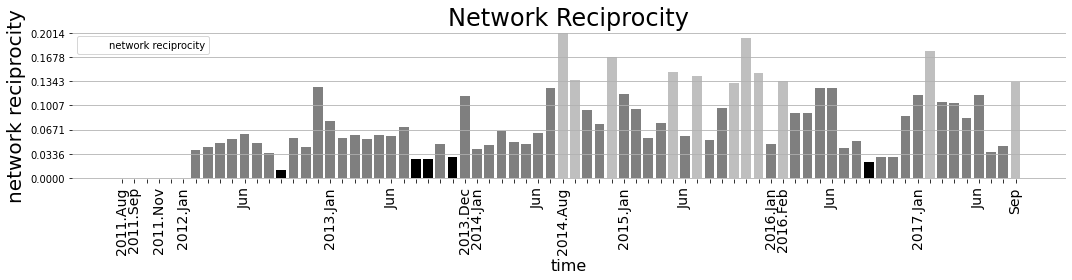

In [178]:
title = 'Network Reciprocity'
reciprocity_plot_x_axis2_color(graph_stats, reciprocity_bar_chart, idxes, idx_labels, label_colors, title, start_idx=36)





# draw graph that delete planner

## we don't use it in JAPA


In [33]:
df_email = pd.read_csv('planner_email.csv')

In [34]:
by = 'month'
idxes, idx_labels, label_colors = seperate_emails(df_email, by, date_col = 'date_sent')

In [35]:
adj_folder = "./adj_planner_merge_then_delete_planner202207"
graph_stats = cal_graph_stats(adj_folder, idxes, by)

infile ./adj_planner_merge_then_delete_planner202207/adjmat_month_0.npz not found! Indicating no email found during the period.
infile ./adj_planner_merge_then_delete_planner202207/adjmat_month_1.npz not found! Indicating no email found during the period.
infile ./adj_planner_merge_then_delete_planner202207/adjmat_month_2.npz not found! Indicating no email found during the period.
infile ./adj_planner_merge_then_delete_planner202207/adjmat_month_3.npz not found! Indicating no email found during the period.
infile ./adj_planner_merge_then_delete_planner202207/adjmat_month_4.npz not found! Indicating no email found during the period.
infile ./adj_planner_merge_then_delete_planner202207/adjmat_month_5.npz not found! Indicating no email found during the period.
infile ./adj_planner_merge_then_delete_planner202207/adjmat_month_6.npz not found! Indicating no email found during the period.
infile ./adj_planner_merge_then_delete_planner202207/adjmat_month_7.npz not found! Indicating no email f

In [36]:
centrality_folder = "./delete_planner_centrality"
centrality_name = 'closeness'
alpha = 1
closeness_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)

infile ./delete_planner_centrality/month_1_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_2_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_3_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_4_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_5_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_6_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_7_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_8_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrali

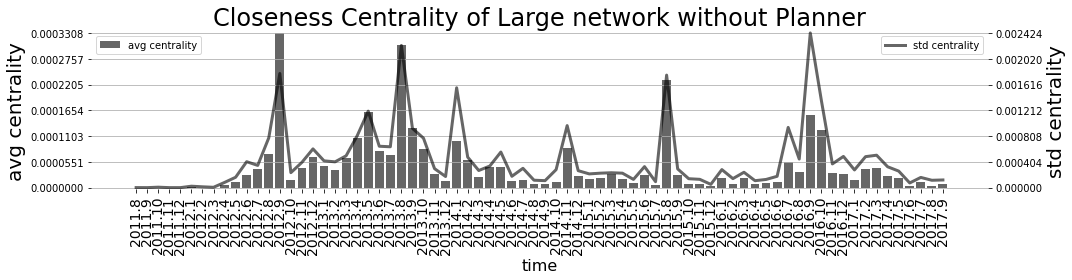

In [37]:

title = 'Closeness Centrality of Large network without Planner'
centrality_density_plot(graph_stats, closeness_stats, idxes, idx_labels, label_colors, title, start_idx=36)


In [38]:
def centrality_density_plot(graph_stats, centrality_stats, idxes, idx_labels, label_colors, title, start_idx = 0):
    fig, ax1 = plt.subplots(figsize = (15,4))

    x = centrality_stats[start_idx:,1]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(title, fontsize = 24)
    ax1.bar(np.arange(len(idxes)-start_idx), x, label = 'avg centrality', alpha = 0.6, color = 'black')
    ax1.legend(loc=2)
    # the range is too large
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,10], y2 = centrality[:,8], color = 'red', alpha = 0.3)
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,9] + centrality[:,11], y2 = centrality[:,9] - centrality[:,11], color = 'red', alpha = 0.3)
    ax1.set_xticks(np.arange(len(idxes)-start_idx))
    ax1.set_xticklabels(idx_labels[start_idx:], rotation = 90, fontsize = 14)
    ax1.set_xlabel('time', fontsize = 16)
    ax1.set_ylabel('avg centrality', color='black', fontsize = 20)
    ax1.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax1.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    #for ticklabel in plt.gca().get_xticklabels():
    #    ticklabel.set_color(label_colors[ticklabel.get_text()])
    ax1.grid(axis = 'y')

#     x = centrality_stats[start_idx:,3]
#     ax2 = ax1.twinx()
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['bottom'].set_visible(False)
    
    
#     ax2.plot(x ,label = 'std centrality', c = 'black', linewidth = 3, ls = 'dashed')
#     ax2.set_ylabel('std centrality', color='black', fontsize = 20, x = 2.4, y = 0.5)
#     ax2.yaxis.set_label_coords(-0.14 ,0.5) 
#     ax2.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax2.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax2.legend(loc=2, bbox_to_anchor=(0.0,0.9))

    x =centrality_stats[start_idx:,3]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.plot(x, label = 'std centrality', c = 'black', linewidth = 3, alpha = 0.6)
    ax3.set_ylabel('std centrality', color='black', fontsize = 20)
    ax3.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax3.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    ax3.legend(loc=1)


    #x = graph_stats[start_idx:,1]
    
    #ax4 = ax1.twinx()
    #ax4.spines['right'].set_visible(False)
    #ax4.spines['left'].set_visible(False)
    #ax4.spines['top'].set_visible(False)
#     ax4.spines['bottom'].set_visible(False)
#     ax4.spines["right"].set_position(("axes", 1.08))
#     ax4.plot(x, label = 'modified density', c = 'black', linewidth = 2, alpha = 0.6)
#     ax4.set_ylabel('modified density', color='black', fontsize = 20, x = 1.2, y = 0.5)
#     ax4.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax4.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax4.legend(loc=1, bbox_to_anchor=(1.0,0.9))

    plt.tight_layout()
  #  plt.show()
    plt.savefig("delete planner betweenness centrality.png",dpi=300)
    

In [39]:
centrality_folder = "./delete_planner_centrality"
centrality_name = 'betweenness'
alpha = 1
betweenness_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)

infile ./delete_planner_centrality/month_1_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_2_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_3_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_4_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_5_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_6_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_7_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_8_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./delete_

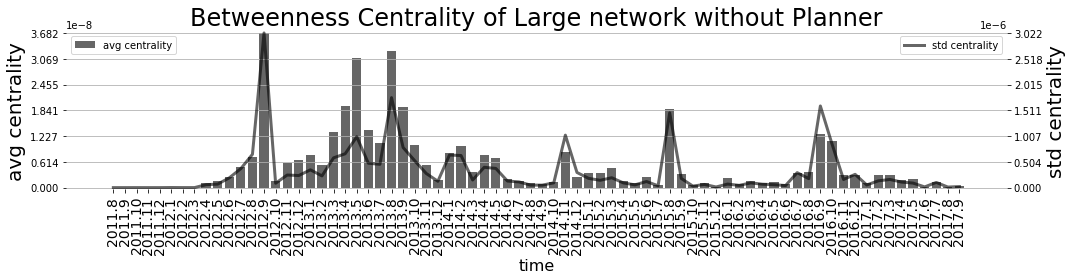

In [40]:
title = 'Betweenness Centrality of Large network without Planner'
centrality_density_plot(graph_stats, betweenness_stats, idxes, idx_labels, label_colors, title, start_idx=36)


In [55]:
def centrality_density_plot(graph_stats, centrality_stats, idxes, idx_labels, label_colors, title, start_idx = 0):
    fig, ax1 = plt.subplots(figsize = (15,4))

    x = centrality_stats[start_idx:,1]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(title, fontsize = 24)
    ax1.bar(np.arange(len(idxes)-start_idx), x, label = 'avg centrality', alpha = 0.6, color = 'black')
    ax1.legend(loc=2)
    # the range is too large
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,10], y2 = centrality[:,8], color = 'red', alpha = 0.3)
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,9] + centrality[:,11], y2 = centrality[:,9] - centrality[:,11], color = 'red', alpha = 0.3)
    ax1.set_xticks(np.arange(len(idxes)-start_idx))
    ax1.set_xticklabels(idx_labels[start_idx:], rotation = 90, fontsize = 14)
    ax1.set_xlabel('time', fontsize = 16)
    ax1.set_ylabel('avg centrality', color='black', fontsize = 20)
    ax1.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax1.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    #for ticklabel in plt.gca().get_xticklabels():
    #    ticklabel.set_color(label_colors[ticklabel.get_text()])
    ax1.grid(axis = 'y')

#     x = centrality_stats[start_idx:,3]
#     ax2 = ax1.twinx()
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['bottom'].set_visible(False)
    
    
#     ax2.plot(x ,label = 'std centrality', c = 'black', linewidth = 3, ls = 'dashed')
#     ax2.set_ylabel('std centrality', color='black', fontsize = 20, x = 2.4, y = 0.5)
#     ax2.yaxis.set_label_coords(-0.14 ,0.5) 
#     ax2.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax2.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax2.legend(loc=2, bbox_to_anchor=(0.0,0.9))

    x =centrality_stats[start_idx:,3]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.plot(x, label = 'std centrality', c = 'black', linewidth = 3, alpha = 0.6)
    ax3.set_ylabel('std centrality', color='black', fontsize = 20)
    ax3.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax3.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    ax3.legend(loc=1)


    #x = graph_stats[start_idx:,1]
    
    #ax4 = ax1.twinx()
    #ax4.spines['right'].set_visible(False)
    #ax4.spines['left'].set_visible(False)
    #ax4.spines['top'].set_visible(False)
#     ax4.spines['bottom'].set_visible(False)
#     ax4.spines["right"].set_position(("axes", 1.08))
#     ax4.plot(x, label = 'modified density', c = 'black', linewidth = 2, alpha = 0.6)
#     ax4.set_ylabel('modified density', color='black', fontsize = 20, x = 1.2, y = 0.5)
#     ax4.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax4.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax4.legend(loc=1, bbox_to_anchor=(1.0,0.9))

    plt.tight_layout()
    plt.show()
#     plt.savefig("delete planner degree centrality.png",dpi=300)
    

In [56]:
centrality_folder = "./delete_planner_centrality"
centrality_name = 'degree'
alpha = 1
degree_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)

infile ./delete_planner_centrality/month_1_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_2_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_3_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_4_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_5_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_6_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_7_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_8_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./delete_planner_centrality/month_9_alpha_1_degre

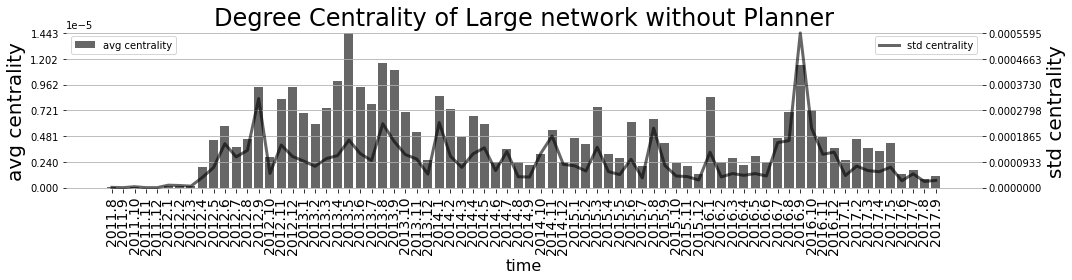

In [57]:
title = 'Degree Centrality of Large network without Planner'
centrality_density_plot(graph_stats, degree_stats, idxes, idx_labels, label_colors, title, start_idx=36)
